In [1]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.optimize as op
import scipy.stats as stt
import matplotlib
from sklearn.decomposition import PCA
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [3]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph, get_all_transitions, get_transitions_state

In [4]:
import mecll

In [5]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/mecll/dynamics/")

In [6]:

from unitary_dynamics import *

In [97]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps,frm_stability = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps,frm_stability = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, frm_stability, task_event_df,seq0,seq1,graph_type0,graph_type1

In [100]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    print('warning not calculating stability just setting to 1')
    return firing_rate_maps, np.ones(n_neurons)
                                         

In [113]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    firing_rate_maps1 = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    firing_rate_maps2 = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan

    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            
            half = len(table_index) //2
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
            firing_rate_maps1[:,int(port),int(task)] = np.nanmean(response_table[table_index[:half]],axis=0)
            firing_rate_maps2[:,int(port),int(task)] = np.nanmean(response_table[table_index[half:]],axis=0)
        
    ccs = []
    for n in range(n_neurons):
        cc = np.corrcoef(firing_rate_maps1[n].flatten(),firing_rate_maps2[n].flatten())[0,1]
        if np.isnan(cc): cc=-100
        ccs.append(cc)
    return firing_rate_maps,ccs

In [114]:
def zscore_population_activity(dat):
    out = (dat - np.mean(dat,axis=0))/np.std(dat,axis=0)
    out = out[:,~np.isnan(np.sum(out,axis=0))]
    return out

In [115]:

firing_rate_maps,frm_stability, task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(1)
mds_frm = firing_rate_maps.swapaxes(0,2)
mds_frm = zscore_population_activity(np.vstack(mds_frm))
act_matrix = mds_frm[:9][seq0]
act_matrix2 = mds_frm[9:][seq1]
mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
print(graph_type0,graph_type1)

loop loop


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [13]:
grad_predict_all = grad(predict_all)

In [14]:
from sklearn.decomposition import PCA
pca_dim = 8
pca = PCA(n_components=pca_dim)

In [15]:
mds_frm.shape

(2, 9, 205)

In [16]:
pca.fit(np.vstack(mds_frm))
pca_activity = pca.transform(mds_frm[0])
pca_activity2 = pca.transform(mds_frm[1])

In [17]:
pca_activity.shape

(9, 8)

In [18]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,pca_dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

KeyboardInterrupt: 

In [19]:
print(res.fun,res.message)

NameError: name 'res' is not defined

In [20]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

NameError: name 'res' is not defined

In [21]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

NameError: name 'Ainf' is not defined

In [22]:
ix_ = 17
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix[:,ix_][1:])

NameError: name 'predicted_neural_activity' is not defined

In [23]:
#seaborn.distplot(np.array(cc)[~np.isnan(cc)],kde=0)

In [24]:
cc = []
n_neurons = act_matrix.shape[1]
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.nanmean(cc))

NameError: name 'predicted_neural_activity' is not defined

In [25]:
np.nanargmax(cc)

ValueError: attempt to get argmax of an empty sequence

In [26]:
act_matrix[:,17]

array([-0.30954129,  0.33540672,  0.19027841, -0.69133282,  0.08294085,
        0.50931452,  1.54697806,  2.09884256,  1.64959749])

## Now try other direction


In [27]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

NameError: name 'Ainf' is not defined

In [28]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix2[:,ix_][1:])

NameError: name 'predicted_neural_activity' is not defined

In [29]:
true_cc = []
print(act_matrix2[:,0])
for i in range(n_neurons):
    true_cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
true_cc = np.nanmean(true_cc)
print(true_cc)

[-0.24253563 -0.24253563 -0.24253563 -0.24253563 -0.24253563 -0.24253563
 -0.24253563  4.12310563 -0.24253563]


NameError: name 'predicted_neural_activity' is not defined

In [30]:
[-0.36952234 -0.78147718 -0.08939304  0.36349151  0.29372497 -0.42719602
 -1.20991022 -1.23987058 -0.76170335]


SyntaxError: invalid syntax (<ipython-input-30-a745e2a64958>, line 1)

In [31]:
all_cc = []
for _ in range(200):
    cc = []
    new_order = np.random.permutation(np.arange(9))
    for i in range(n_neurons):
        cc.append(np.corrcoef(act_matrix2[:,i][new_order][1:],predicted_neural_activity[:,i][:-1])[0,1])
    all_cc.append(np.nanmean(cc))
#print(np.nanmean(cc))

NameError: name 'predicted_neural_activity' is not defined

In [32]:
act_matrix.shape

(9, 205)

In [33]:
predicted_neural_activity.shape

NameError: name 'predicted_neural_activity' is not defined

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

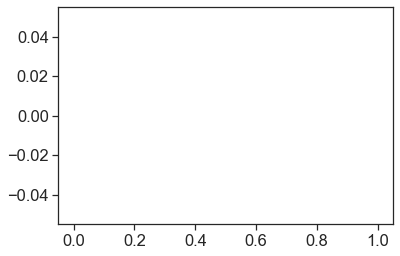

In [34]:
seaborn.distplot(all_cc,kde=0)
plt.axvline(x=true_cc)

In [35]:
np.allclose(act_matrix,act_matrix2)

False

In [36]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][np.random.permutation(np.arange(9))],np.roll(predicted_neural_activity[:,i],1))[0,1])
    
print(np.nanmean(cc))

NameError: name 'predicted_neural_activity' is not defined

# Now implement this as a batch thing

In [37]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(5):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity)[0])
    params = fit_params[np.argmax(fit_quality)]
    skewM = np.einsum('i...,i...',params,basis_tensor_inf)
    Ainf = caley_transform(skewM,pca_dim)

    print(fit_quality)
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)[0]
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2[::-1].T).T)
    res2 = evaluate_cc(neural_activity2[::-1],predicted_neural_activity2)[0]
    res = np.max([res,res2])
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(2000):
        
        perm_order = np.random.permutation(r9)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)

        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)[0]
        shf_res2 = evaluate_cc(neural_activity2[perm_order][::-1],predicted_neural_activity2_shuff[::-1])[0]
        shuffle_res.append(np.max([shf_res,shf_res2]))
    return res, shuffle_res, Ainf
    

In [38]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    #true_cc_val = np.nanmean(true_cc)
    return np.nanmean(true_cc),true_cc

In [39]:
print(graph_type0,graph_type1)

loop loop


In [119]:
all_res = []
all_shuffle_res = []
for session_ix in range(1):

    firing_rate_maps, frm_stability, task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(session_ix)
    firing_rate_maps = firing_rate_maps[np.array(frm_stability)>.3]
    
    mds_frm = firing_rate_maps.swapaxes(0,2)
    mds_frm = zscore_population_activity(np.vstack(mds_frm))
    act_matrix = mds_frm[:9][seq0] - np.mean(mds_frm[:9][seq0],axis=0)
    act_matrix2 = mds_frm[9:][seq1]- np.mean(mds_frm[9:][seq1],axis=0)

    
    mds_frm = np.dstack([act_matrix,act_matrix2]).swapaxes(0,2).swapaxes(1,2)
    #print(graph_type0,graph_type1)
    pca_dim = 8
    pca = PCA(n_components=pca_dim)
    
    pca.fit(np.vstack(mds_frm))
    pca_activity = pca.transform(mds_frm[0])
    pca_activity2 = pca.transform(mds_frm[1])
    fit_res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca)
    all_res.append(fit_res)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[0.609545913222877, 0.6339337930498903, 0.6339655223109547, 0.6106458553672331, 0.6128281471064894]
0.2212099228764908


In [47]:
pca_activity2.shape

(9, 8)

In [48]:
#Ainf = caley_transform(skewM,pca_dim)
Ainf = fit_res[-1]

predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)
predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
res = evaluate_cc(act_matrix2,predicted_neural_activity2)
res2 = evaluate_cc(act_matrix2[::-1],predicted_neural_activity2[::-1])
res = np.max([res,res2])
shuffle_res = []
print(res)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [80]:
#Ainf = caley_transform(skewM,pca_dim)
Ainf = fit_res[-1]

predicted_pc = (Ainf@pca_activity.T).T
predicted_neural_activity = pca.inverse_transform(predicted_pc)
res1,cc = evaluate_cc(act_matrix,predicted_neural_activity)
cc = np.array(cc)


predicted_pc2 = (Ainf@pca_activity2.T).T
print(evaluate_cc(pca_activity2,predicted_pc2))
predicted_neural_activity2 = pca.inverse_transform(predicted_pc2)
res2,cc2 = evaluate_cc(act_matrix2,predicted_neural_activity2)


predicted_pc2r = (Ainf@pca_activity2[::-1].T).T
print(evaluate_cc(pca_activity2,predicted_pc2r))
predicted_neural_activity2r = pca.inverse_transform(predicted_pc2r)
res2r,cc2r = evaluate_cc(act_matrix2[::-1],predicted_neural_activity2r)
print(res2,res2r)

if res2r>res2:
    #pca_activity2 = pca_activity2[::-1]
    predicted_pc2 = predicted_pc2r
    predicted_neural_activity2 = predicted_neural_activity2r
    cc2 = cc2r
    
cc2 = np.array(cc2)
res = np.max([res2,res2r])
print(res)


(0.08493880074734678, [0.3837789704604044, -0.5411924588176021, 0.45881675427929297, 0.17545158647217954, 0.2823373212934119, 0.09133485253560727, -0.15985670298707275, -0.011159917257446942])
(0.054181587391091524, [-0.49090543988857616, -0.15843531252513604, 0.23160554243001252, -0.3214072165108006, -0.024362079001754754, 0.5748619707653201, -0.050689790603823705, 0.6727850244634911])
0.03145963978292783 0.08322339138034254
0.08322339138034254


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [81]:
[np.corrcoef(predicted_pc2[:,i][::-1],pca_activity2[:,i])[0,1] for i in range(8)]

[0.7923890175388486,
 -0.21046427152590805,
 -0.3946047943325352,
 -0.5054153026621314,
 -0.5386765475455919,
 -0.20107479562334218,
 -0.03055093729499536,
 -0.22268354325842057]

In [82]:
np.where(np.logical_and.reduce([cc>.5,cc2>0.5,~np.isnan(cc),~np.isnan(cc2)]))[0]

array([  6,  24,  28,  49,  50,  57,  61,  63,  67,  79,  85,  91,  97,
       102, 107, 114, 117, 123, 125, 127])

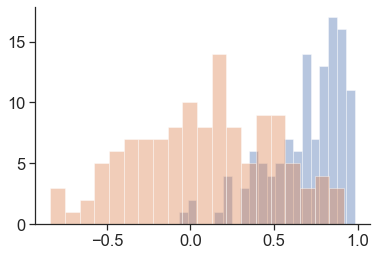

In [83]:
seaborn.distplot(np.array(cc)[~np.isnan(cc)],kde=0,bins=20)
seaborn.despine()

seaborn.distplot(np.array(cc2)[~np.isnan(cc2)],kde=0,bins=20)
seaborn.despine()

In [84]:
np.nanmean(cc)

0.6854551064848038

In [85]:
gIxs = np.where(np.logical_and.reduce([cc>.6,cc2>0.6,~np.isnan(cc),~np.isnan(cc2)]))[0]

In [86]:
cc[gIxs]

array([0.80841716, 0.91432077, 0.76812348, 0.60109577, 0.78995012,
       0.76652845, 0.90836191, 0.77056032, 0.93815661, 0.82192998,
       0.87484506, 0.85528865])

In [87]:
cc2[gIxs]

array([0.86268009, 0.72156753, 0.62417914, 0.61031694, 0.87707845,
       0.80986052, 0.70618736, 0.69688414, 0.78164208, 0.65121818,
       0.91823309, 0.75424587])

In [88]:
print(gIxs)

[  6  28  57  61  79  91  97 102 114 117 123 127]


In [89]:
seq0_inv = [seq0.tolist().index(i) for i in range(9)]
seq1_inv = [seq1.tolist().index(i) for i in range(9)]


In [90]:
cc_ = []
for kk in gIxs:
    cc_.append(np.corrcoef(act_matrix[:,kk][seq0_inv],act_matrix2[:,kk][seq1_inv])[0,1])

In [91]:
cc_bad = []
cc_good = []
for kk in range(act_matrix.shape[1]):
    if kk not in gIxs:
        cc_bad.append(np.corrcoef(act_matrix[:,kk][seq0_inv],act_matrix2[:,kk][seq1_inv])[0,1])
    else:
        cc_good.append(np.corrcoef(act_matrix[:,kk][seq0_inv],act_matrix2[:,kk][seq1_inv])[0,1])

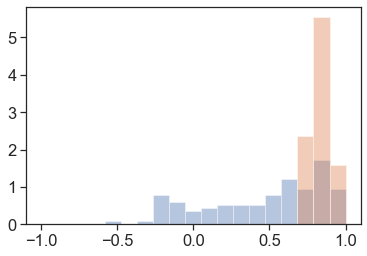

In [92]:
seaborn.distplot(np.array(cc_bad)[np.isfinite(cc_bad)],bins=np.linspace(-1,1,num=20),kde=0,norm_hist=1)
seaborn.distplot(np.array(cc_good)[np.isfinite(cc_good)],bins=np.linspace(-1,1,num=20),kde=0,norm_hist=1)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


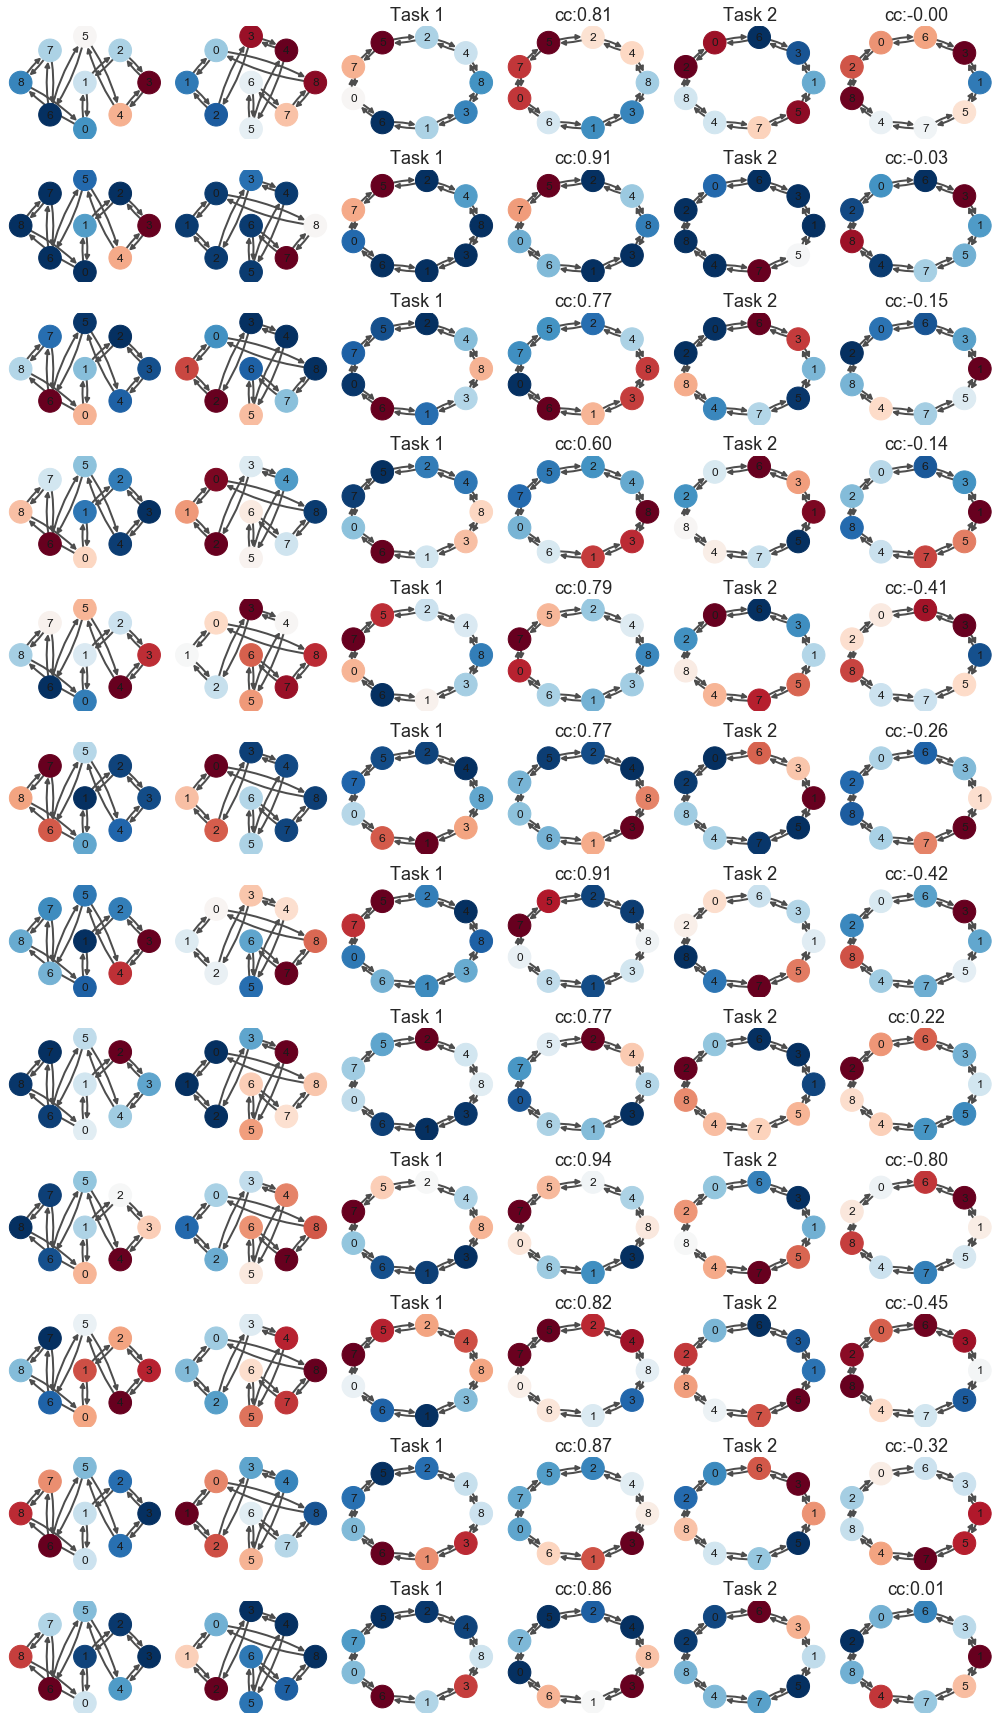

In [93]:

nG = len(gIxs)


plt.figure(figsize=(14,2*nG))
for kk in range(nG):
    
    ix = gIxs[kk]
    plt.subplot(nG,6,6*kk+1)
    plot_activity_on_graph(seq0.tolist(),
                           graph_type0,
                           spks=act_matrix[:,ix][seq0_inv].tolist(),
                           mn=np.min(act_matrix[:,ix])
                          )

    plt.subplot(nG,6,6*kk+2)
    plot_activity_on_graph(seq1.tolist(),
                           graph_type1,
                           spks=act_matrix2[:,ix][seq1_inv].tolist(),
                           mn=np.min(act_matrix[:,ix])
                          )


    plt.subplot(nG,6,6*kk+3)
    plt.title("Task 1")
    plot_activity_on_graph(sequence=seq0.tolist(),
                           graph_type=graph_type0,
                           spks=act_matrix[:,ix],
                           order='state',
                           mn=np.min(act_matrix[:,ix])
                          )

    plt.subplot(nG,6,6*kk+5)
    plt.title("Task 2")
    plot_activity_on_graph(seq1.tolist(),
                           graph_type1,
                           spks=act_matrix2[:,ix],
                           order='state',
                           mn=np.min(act_matrix2[:,ix])
                          )
    
    
    plt.subplot(nG,6,6*kk+4)
    plt.title('cc:{:.2f}'.format(np.corrcoef(act_matrix[:,ix][1:],predicted_neural_activity[:,ix][:-1])[0,1]))
    plot_activity_on_graph(sequence=seq0.tolist(),
                           graph_type=graph_type0,
                           spks=np.roll(predicted_neural_activity[:,ix],1),
                           order='state',
                           mn=np.min(act_matrix[:,ix])
                          )
    plt.gca().set_facecolor('grey') 

    plt.subplot(nG,6,6*kk+6)
    plt.title('cc:{:.2f}'.format(np.corrcoef(act_matrix2[:,ix],np.roll(predicted_neural_activity2[:,ix],1))[0,1]))

    plot_activity_on_graph(seq1.tolist(),
                           graph_type1,
                           spks=np.roll(predicted_neural_activity2[:,ix],1),
                           order='state',mn=np.min(act_matrix[:,ix])
                          )
    plt.gca().set_facecolor('.3') 
plt.tight_layout()

0
1
2
3


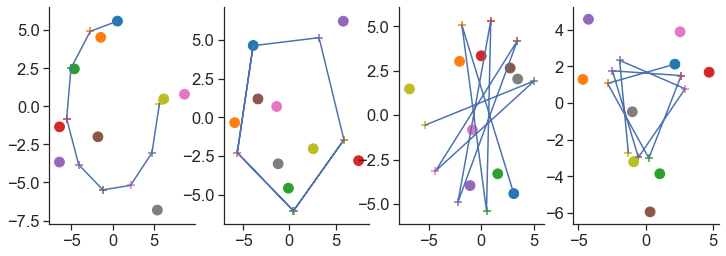

In [68]:
evals, evecs = np.linalg.eig(Ainf)
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real
dim = Ainf.shape[0]
x = pca_activity
ideal_activity = [np.linalg.matrix_power(Ainf,i)@x[0] for i in range(9)]
plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    #plt.plot(*(projection))
    
    projection2 = (np.squeeze(ideal_activity)@w).T
    plt.plot(*(projection2))
    plt.scatter(projection2[0],projection2[1],c=seaborn.color_palette("tab10",n_colors=9),marker='+',s=64)


    
    plt.scatter(projection[0],projection[1],c=seaborn.color_palette("tab10",n_colors=9),s=96)

seaborn.despine()

In [75]:
res2

0.03145963978292783

0
1
2
3


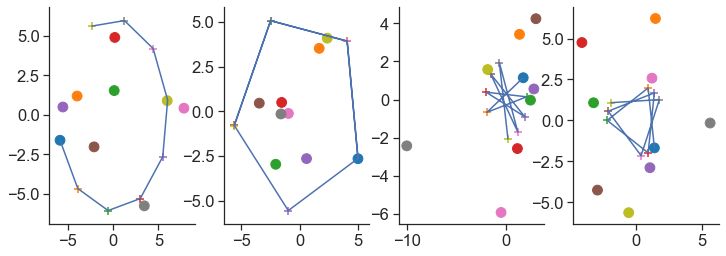

In [78]:

evals, evecs = np.linalg.eig(Ainf)
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real
dim = Ainf.shape[0]
x = pca_activity2
if res2r>res2:
    x = x[::-1]
    ideal_activity = [np.linalg.matrix_power(Ainf,i)@x[0] for i in range(9)]
else:
    ideal_activity = [np.linalg.matrix_power(Ainf,i)@x[0] for i in range(9)]
plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    #plt.plot(*(projection))
    
    projection2 = (np.squeeze(ideal_activity)@w).T
    plt.plot(*(projection2))
    plt.scatter(projection2[0],projection2[1],c=seaborn.color_palette("tab10",n_colors=9),marker='+',s=64)


    
    plt.scatter(projection[0],projection[1],c=seaborn.color_palette("tab10",n_colors=9),s=96)

seaborn.despine()

In [79]:
np.abs(projection - projection2).sum()

48.183481851059774

0
1
2
3


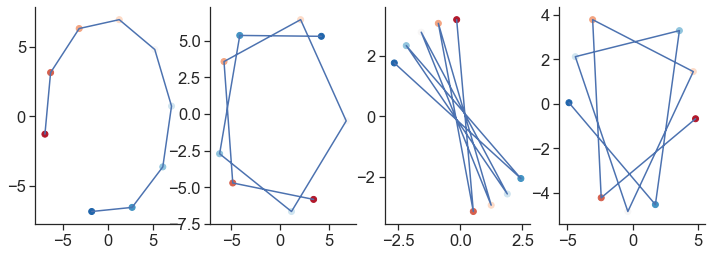

In [322]:
evals, evecs = np.linalg.eig(Ainf)
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real
dim = Ainf.shape[0]
x = ideal_activity
plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    plt.plot(*(projection))
    plt.scatter(projection[0],projection[1],c=seaborn.color_palette("RdBu_r",n_colors=9))

seaborn.despine()